# Multilevel hierarchical Bayesian modeling of cross-national factors in SUV sales

## Model Comparison

In [21]:
import cmdstanpy
cmdstanpy.install_cmdstan()
cmdstanpy.install_cmdstan(compiler=True)

from cmdstanpy import CmdStanModel
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import arviz as az
import seaborn as sns
from scipy.stats import lognorm, norm, expon

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

CmdStan install directory: /root/.cmdstan
CmdStan version 2.34.1 already installed
Test model compilation
CmdStan install directory: /root/.cmdstan
CmdStan version 2.34.1 already installed
Test model compilation


In [22]:
!pip install --upgrade cmdstanpy arviz

## Auxiliary Functions

In [23]:
def plot_suv_sales_world_map(countries: np.ndarray, sales: np.ndarray, isPred: bool) -> None:
    """
    Plots a map showing the distribution of SUV sales across the world.

    Parameters:
    - countries (np.ndarray): Array of country names corresponding to the sales data.
    - sales (np.ndarray): Array of sales figures corresponding to each country.
    - isPred (bool): Flag to determine whether the sales data includes predictions. If True, the sales
      data is averaged across all predictions before plotting.

    Returns:
    - None: This function directly displays the plot and does not return any value.
    """
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    if isPred:
        sales = np.mean(sales, axis=0)

    sales_data = pd.DataFrame({
        'country': countries,
        'SUV_sales': sales
    })

    world_with_sales = world.merge(sales_data, how='left', left_on='name', right_on='country')

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    plt.title('World Map of SUV Sales')
    world_with_sales.boundary.plot(ax=ax, linewidth=1, color='black')

    vmin, vmax = 0, 1

    world_with_sales.plot(
        column='SUV_sales',
        ax=ax,
        legend=False,
        vmin=vmin,
        vmax=vmax,
        missing_kwds={'color': 'lightgrey', "label": "No Data"},
        cmap='Blues'
    )

    cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])

    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('Fraction of SUV Sales by Country')

    plt.show()

In [24]:
def plot_bar_graph_country_suv_sales(df: pd.DataFrame) -> None:
    """
    Plots a bar graph of actual SUV sales by country.

    Parameters:
    - df (pd.DataFrame): DataFrame with at least two columns: 'country' and 'SUV_sales'.
      'country' column contains the names of the countries as strings.
      'SUV_sales' column contains the sales figures as floats.

    Returns:
    - None: The function directly displays the plot and does not return any value.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    N = df.shape[0]
    real_sales = df['SUV_sales'].values
    country_names = df['country'].values
    samples = np.arange(N) + 1

    fig, ax = plt.subplots(figsize=(15, 5))

    bars = ax.bar(samples, real_sales*100, width=0.4, color='tab:blue', alpha=0.7, edgecolor='black')

    ax.set_xlabel('Country', fontsize=12)
    ax.set_ylabel('SUV Sales', fontsize=12)
    ax.set_title('Actual SUV Sales by Country', fontsize=14)
    ax.legend(['SUV Sales'], fontsize='small')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    ax.set_xticks(samples)
    ax.set_xticklabels(country_names, rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{height:.2f} %', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## Basic Dataset

*   Downloading data file from Google Drive
*   Creating a Dataframe with the sheet data
*   Initial data preprocessing

To run that code you need to export the `SUV_Sales_basic_dataset.csv` file from [SUV Sales Determination Dataset](https://github.com/sukiennik-monika/SUV-Sales-Determination-Dataset) to Google Sheets, integrated this Google Collaboratory.

In [25]:
creds, _ = default()
gc = gspread.authorize(creds)
worksheet = gc.open('da_dataset').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows)

df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.iloc[:,:-1]
df = df.apply(lambda x: x.str.replace(',','.'))
df['country'].replace({
    'United States': 'United States of America',
    'Czech Republic': 'Czechia'
}, inplace=True)
df['SUV_sales'] = df['SUV_sales'].astype(float) / 100
df.head()

,country,SUV_sales,roads_quality,mountains,wage,fuel_price,fertility_rate,,
1,Albania,0.4007,3.90,70.80,404.02,2.09,1.60,,
2,Argentina,0.1613,3.60,30.00,427.94,0.90,2.20,,
3,Australia,0.5065,4.90,6.00,4218.89,1.35,1.80,,
4,Austria,0.4296,6.00,73.80,2175.48,1.87,1.50,,
5,Belgium,0.4395,4.40,4.40,2354.96,1.98,1.60,,


* Changing all rows data type to float

In [26]:
df = df.astype({'SUV_sales':'float',
                'roads_quality':'float',
                'mountains':'float',
                'wage':'float',
                'fuel_price':'float',
                'fertility_rate':'float'})

* Data rescaling using min-max normalization method

In [27]:
df['minmax_wage'] = (df.wage - df.wage.min()) / (df.wage.max() - df.wage.min())
df['minmax_roads_quality'] = (df.roads_quality - df.roads_quality.min()) / (df.roads_quality.max() - df.roads_quality.min())
df['minmax_mountains'] = (df.mountains - df.mountains.min()) / (df.mountains.max() - df.mountains.min())
df['minmax_fuel_price'] = (df.fuel_price - df.fuel_price.min()) / (df.fuel_price.max() - df.fuel_price.min())
df.head()

,country,SUV_sales,roads_quality,mountains,wage,fuel_price,fertility_rate,,,minmax_wage,minmax_roads_quality,minmax_mountains,minmax_fuel_price
1,Albania,0.4007,3.9,70.8,404.02,2.09,1.6,,,0.015395,0.264706,0.846890,0.886486
2,Argentina,0.1613,3.6,30.0,427.94,0.90,2.2,,,0.019500,0.176471,0.358852,0.243243
3,Australia,0.5065,4.9,6.0,4218.89,1.35,1.8,,,0.669994,0.558824,0.071770,0.486486
4,Austria,0.4296,6.0,73.8,2175.48,1.87,1.5,,,0.319362,0.882353,0.882775,0.767568
5,Belgium,0.4395,4.4,4.4,2354.96,1.98,1.6,,,0.350160,0.411765,0.052632,0.827027


* Plot of a world map with SUV sales data from the dataset

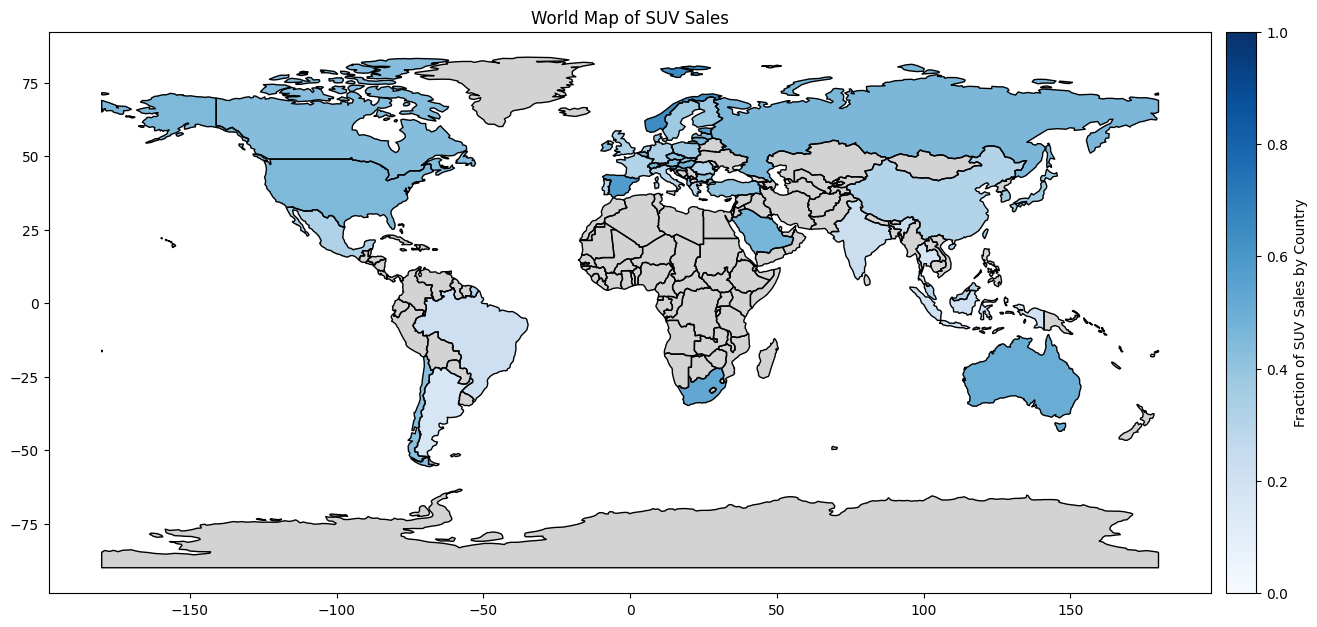

In [28]:
plot_suv_sales_world_map(df['country'].values, df['SUV_sales'].values, False)

## First Model

Model structure

In [29]:
model_all_param_code = """
                data {
                  int<lower=1> N;                // Number of data points
                  vector[N] sales;               // SUV car sales
                  vector[N] roads_quality;       // Roads quality
                  vector[N] mountains_area;      // Mountains area per country
                  vector[N] wages;               // Average wage
                  vector[N] fuel_price;          // Fuel prices
                }

                parameters {
                  real alpha;                    // Intercept
                  real<lower=0> beta_fuel_price; // Coefficient for fuel prices
                  real<lower=0> beta_wage;       // Coefficient for average wage
                  real<lower=0> beta_roads_quality; // Coefficient for roads quality
                  real<lower=0> beta_mountains;  // Coefficient for mountains area
                  real<lower=0.01> sigma;        // Standard deviation
                }

                transformed parameters {
                  vector[N] mu;
                  mu = alpha +
                      wages * beta_wage +
                      fuel_price * beta_fuel_price +
                      roads_quality * beta_roads_quality +
                      mountains_area * beta_mountains;
                }

                model {
                  // Priors
                   alpha ~ normal(0, 0.25);
                   beta_fuel_price ~ normal(0, 0.25);
                   beta_wage ~ normal(0, 0.25);
                   beta_roads_quality ~ normal(0, 0.25);
                   beta_mountains ~ normal(0, 0.25);
                   sigma ~ normal(0, 0.1);

                  // Likelihood
                  sales ~ normal(mu, sigma*sigma);
                }

                generated quantities {
                  vector[N] sales_pred;
                  vector[N] log_likelihood;
                  for (i in 1:N) {
                    sales_pred[i] = normal_rng(mu[i], sigma*sigma);
                    log_likelihood[i] = normal_lpdf(sales[i] | mu[i], sigma*sigma);
                  }
                }

"""

with open('model_all_param.stan', 'w') as file:
    file.write(model_all_param_code)

* Creating CmdStanModel with model structure
* Sampling model with dataset values

In [30]:
data2 = dict(
    N=len(df),
    sales=df.SUV_sales.values,
    roads_quality=df.minmax_roads_quality.values,
    mountains_area=df.minmax_mountains.values,
    wages=df.minmax_wage.values,
    fuel_price=df.minmax_fuel_price.values)

model2 = CmdStanModel(stan_file='model_all_param.stan')
fit2 = model2.sample(data2,
                     seed=28052020,
                     iter_sampling=4000,
                     show_progress=False)

## Second Model

Model structure

In [31]:
model_all_param_not_cen_code = """
                data {
                  int<lower=1> N;                // Number of data points
                  vector[N] sales;               // SUV car sales
                  vector[N] roads_quality;       // Roads quality
                  vector[N] mountains_area;      // Mountains area per country
                  vector[N] wages;               // Average wage
                  vector[N] fuel_price;          // Fuel prices
                }

                parameters {
                  real alpha;                    // Intercept
                  real<lower=0> beta_fuel_price; // Coefficient for fuel prices
                  real<lower=0> beta_wage;       // Coefficient for average wage
                  real<lower=0> beta_roads_quality; // Coefficient for roads quality
                  real<lower=0> beta_mountains;  // Coefficient for mountains area
                  real<lower=0.01> eta;          // Dispersion parameter
                }

                transformed parameters {
                  vector[N] mu;
                  vector[N] alpha_param;
                  vector[N] beta_param;

                  for (i in 1:N) {
                      mu[i] = inv_logit(alpha +
                            wages[i] * beta_wage +
                            fuel_price[i] * beta_fuel_price +
                            roads_quality[i] * beta_roads_quality +
                            mountains_area[i] * beta_mountains);

                      alpha_param[i] = mu[i]*eta;
                      beta_param[i] = (1-mu[i])*eta;
                  }
                }

                model {
                  // Priors
                   alpha ~ normal(0, 1);
                   beta_fuel_price ~ normal(0, .25);
                   beta_wage ~ normal(0, .25);
                   beta_roads_quality ~ normal(0, .25);
                   beta_mountains ~ normal(0, .25);
                   eta ~ uniform(0, 50);

                  // Likelihood
                  sales ~ beta(alpha_param, beta_param);
                }

                generated quantities {
                  vector[N] sales_pred;
                  vector[N] log_likelihood;
                  vector[N] sigma;

                  for (i in 1:N) {
                    sigma[i] = (mu[i] * (1 - mu[i])) / (eta + 1);
                    sales_pred[i] = beta_rng(alpha_param[i], beta_param[i]);
                    log_likelihood[i] = beta_lpdf(sales[i] | alpha_param[i], beta_param[i]);
                  }
                }

"""

with open('model_all_param_not_cen.stan', 'w') as file:
    file.write(model_all_param_not_cen_code)

* Creating CmdStanModel with model structure
* Sampling model with dataset values

In [32]:
model2_nc = CmdStanModel(stan_file='model_all_param_not_cen.stan')
fit2_nc = model2_nc.sample(data=data2,
                           seed=28052020,
                           iter_sampling=4000,
                           show_progress=True)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

## Third Model

  Model structure

In [33]:
model_all_param_not_cen_st_code = """
                        data {
                          int<lower=1> N;                // Number of data points
                          vector[N] sales;               // SUV car sales
                          vector[N] roads_quality;       // Roads quality
                          vector[N] mountains_area;      // Mountains area per country
                          vector[N] wages;               // Average wage
                          vector[N] fuel_price;          // Fuel prices
                        }

                        parameters {
                          real alpha;                                // Intercept
                          real<lower=0> beta_fuel_price;             // Coefficient for fuel prices
                          real<lower=0> beta_wage;                   // Coefficient for average wage
                          real<lower=0> beta_roads_quality;          // Coefficient for roads quality
                          real<lower=0> beta_mountains;              // Coefficient for mountains area
                          real<lower=0.01> sigma;                    // Standard deviation
                          real <lower = 0> df;                       // Degrees of freedom
                        }

                        transformed parameters {
                          vector[N] mu;
                          mu = alpha +
                              wages * beta_wage +
                              fuel_price * beta_fuel_price +
                              roads_quality * beta_roads_quality +
                              mountains_area * beta_mountains;
                        }

                        model {
                          // Priors
                          alpha ~ normal(0, 1);
                          beta_fuel_price ~ normal(0, 0.25);
                          beta_wage ~ normal(0, 0.25);
                          beta_roads_quality ~ normal(0, 0.25);
                          beta_mountains ~ normal(0, 0.25);
                          sigma ~ normal(0, 0.01);
                          df ~ normal(0,20);

                          sales ~ student_t(df+2, mu, sigma);
                        }

                        generated quantities {
                          vector[N] sales_pred;
                          vector[N] log_likelihood;

                          for (i in 1:N) {
                            sales_pred[i] = student_t_rng(df+2, mu[i], sigma);
                            log_likelihood[i] = student_t_lpdf(sales[i] | df+2, mu[i], sigma);
                          }
                        }
"""

with open('model_all_param_not_cen_st.stan', 'w') as file:
    file.write(model_all_param_not_cen_st_code)

* Creating CmdStanModel with model structure
* Sampling model with dataset values

In [34]:
model2_nc_st = CmdStanModel(stan_file='model_all_param_not_cen_st.stan')
fit2_nc_st = model2_nc_st.sample(data=data2,
                           seed=28052020,
                           iter_sampling=4000,
                           show_progress=True)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

## Fourth Model

  Model structure

In [35]:
model_all_param_not_cen_st_ua_code = """
                        data {
                          int<lower=1> N;                // Number of data points
                          vector[N] sales;               // SUV car sales
                          vector[N] roads_quality;       // Roads quality
                          vector[N] mountains_area;      // Mountains area per country
                          vector[N] wages;               // Average wage
                          vector[N] fuel_price;          // Fuel prices
                        }

                        parameters {
                          vector[N] alpha;
                          real<lower=0> beta_fuel_price;             // Coefficient for fuel prices
                          real<lower=0> beta_wage;                   // Coefficient for average wage
                          real<lower=0> beta_roads_quality;          // Coefficient for roads quality
                          real<lower=0> beta_mountains;              // Coefficient for mountains area
                          real<lower=0.01> sigma;                    // Standard deviation
                          real <lower = 0> df;                       // Degrees of freedom
                          real<lower=0> gamma_param;                 // First param for the alpha
                          real<lower=0.01> delta_param;              // Second param for the alpha
                        }

                        transformed parameters {
                          vector[N] mu;

                          for (i in 1:N) {
                            mu[i] = alpha[i] +
                                wages[i] * beta_wage +
                                fuel_price[i] * beta_fuel_price +
                                roads_quality[i] * beta_roads_quality +
                                mountains_area[i] * beta_mountains;
                            }
                        }

                        model {
                          // Priors
                          beta_fuel_price ~ normal(0, 0.25);
                          beta_wage ~ normal(0, 0.25);
                          beta_roads_quality ~ normal(0, 0.25);
                          beta_mountains ~ normal(0, 0.25);
                          sigma ~ normal(0, 0.01);
                          df ~ normal(0,20);
                          gamma_param ~ normal(0,1);
                          delta_param ~ normal(0,.1);
                          alpha ~ normal(gamma_param, delta_param);

                          sales ~ student_t(df+2, mu, sigma);
                        }

                        generated quantities {
                          vector[N] sales_pred;
                          vector[N] log_likelihood;

                          for (i in 1:N) {
                            sales_pred[i] = student_t_rng(df+2, mu[i], sigma);
                            log_likelihood[i] = student_t_lpdf(sales[i] | df+2, mu[i], sigma);
                          }
                        }
"""

with open('model_all_param_not_cen_st_ua.stan', 'w') as file:
    file.write(model_all_param_not_cen_st_ua_code)

* Creating CmdStanModel with model structure
* Sampling model with dataset values

In [36]:
model2_nc_st_ua = CmdStanModel(stan_file='model_all_param_not_cen_st_ua.stan')
fit2_nc_st_ua = model2_nc_st_ua.sample(data=data2,
                           seed=28052020,
                           iter_sampling=4000,
                           show_progress=True)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

## Model comparison

* Preparing a dictionary with models to comparison

In [37]:
idata2 = az.from_cmdstanpy(fit2, log_likelihood="log_likelihood")
idata2_nc_st = az.from_cmdstanpy(fit2_nc_st, log_likelihood="log_likelihood")
idata2_nc_st_ua = az.from_cmdstanpy(fit2_nc_st_ua, log_likelihood="log_likelihood")
idata2_nc = az.from_cmdstanpy(fit2_nc, log_likelihood="log_likelihood")
compare_dict = {"std_distribution": idata2_nc_st, "std_distribution_with_unique_alpha": idata2_nc_st_ua, "nrm_distribution": idata2, "beta_distribution": idata2_nc}
az.compare(compare_dict, ic="loo")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
std_distribution_with_unique_alpha,0,72.811220,69.994601,0.000000,1.000000e+00,3.538537,0.000000,True,log
beta_distribution,1,42.726503,2.786102,30.084717,0.000000e+00,4.460054,3.190029,False,log
nrm_distribution,2,42.076874,3.859872,30.734346,0.000000e+00,4.404568,2.800244,False,log
std_distribution,3,33.884223,6.354067,38.926997,1.328004e-11,7.556856,5.826303,False,log


* Comparing with LOO information criteria

In [38]:
az.compare(compare_dict, ic="loo")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
std_distribution_with_unique_alpha,0,72.811220,69.994601,0.000000,1.000000e+00,3.538537,0.000000,True,log
beta_distribution,1,42.726503,2.786102,30.084717,0.000000e+00,4.460054,3.190029,False,log
nrm_distribution,2,42.076874,3.859872,30.734346,0.000000e+00,4.404568,2.800244,False,log
std_distribution,3,33.884223,6.354067,38.926997,1.328004e-11,7.556856,5.826303,False,log


* Comparing with WAIC information criteria

In [39]:
az.compare(compare_dict, ic = "waic")

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
std_distribution_with_unique_alpha,0,106.301848,36.503972,0.000000,1.000000e+00,0.722324,0.000000,True,log
beta_distribution,1,42.745723,2.766882,63.556125,3.207157e-13,4.454254,3.824976,False,log
nrm_distribution,2,42.153131,3.783615,64.148718,3.732292e-13,4.393898,3.736720,True,log
std_distribution,3,33.937282,6.301008,72.364566,0.000000e+00,7.557752,6.938195,False,log


* Plot of LOO model comparison

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

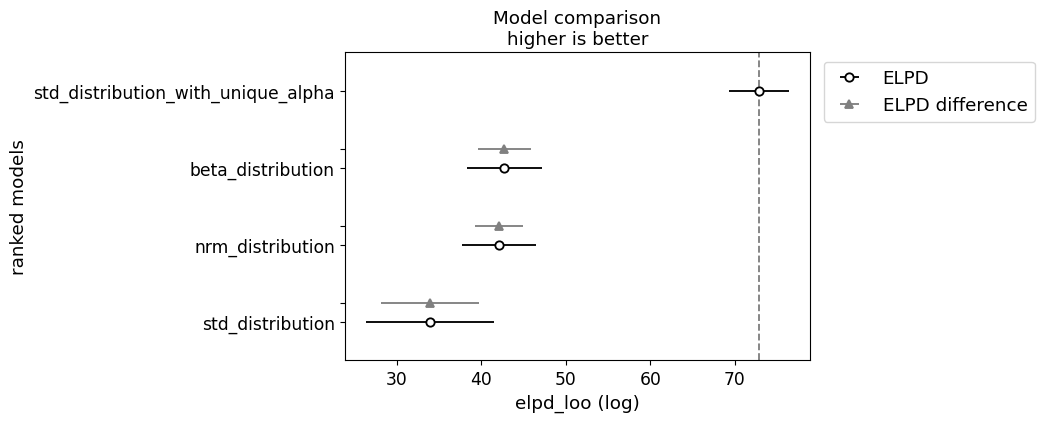

In [40]:
az.plot_compare(az.compare(compare_dict, ic="loo"))

* Plot of WAIC model comparison

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

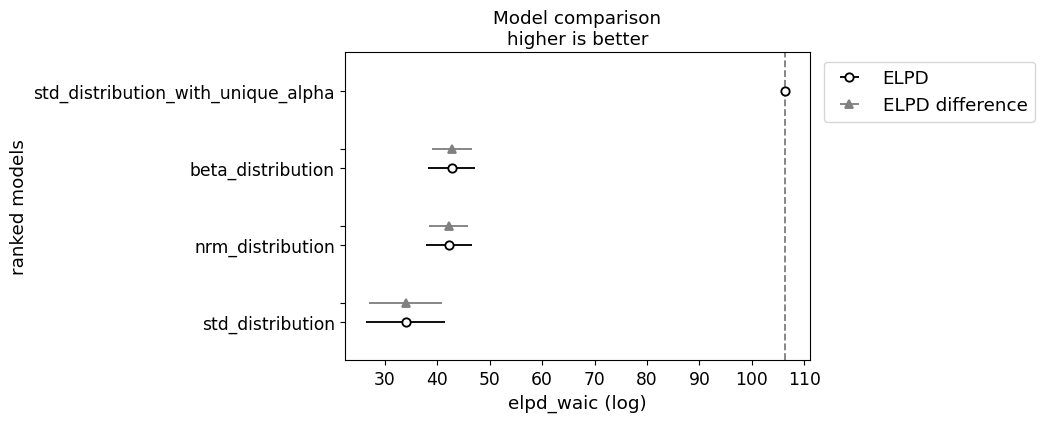

In [41]:
az.plot_compare(az.compare(compare_dict, ic="waic"))